In [1]:
from Params.path_params import Data_path
import pandas as pd
import numpy as np
import numpy as np
import matplotlib.pylab as plt
from sklearn.preprocessing import MinMaxScaler
import re

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
def get_login_features(df, col='id', time_range='1D', feature_cols=[]):
    """
    this function usde to get login features
    :param df:
    :param col:
    :param feature_cols:
    :param time_range:
    :return:
    """
    df_g = df.groupby(col)[feature_cols].rolling(time_range).apply(lambda x: np.unique(x).shape[0])
    df_g = df_g.reset_index(0).sort_index().drop(col, axis=1)
    rename_cols = {x: "new_{0}_login_{1}_{2}_num".format(col, x, time_range) for x in feature_cols}
    df_g = df_g.rename(columns=rename_cols)
    return df_g, rename_cols

In [4]:
def get_not_net_features(df, col='id', time_range='1D', feature_cols=[]):
    """
    获取非网络特征
    :param df:
    :param time_range:
    :param feature_cols:
    :return:
    """

    def get_max_count(x):
        (values, counts) = np.unique(x, return_counts=True)
        ind = np.argmax(counts)
        return values[ind]

    df[feature_cols] = df[feature_cols].astype(int)
    df_g = df.groupby(col)[feature_cols].rolling(time_range).apply(lambda x: get_max_count(x))
    df_g = df_g.reset_index(0).sort_index().drop(col, axis=1)
    rename_cols = {x: "new_anomaly_{0}_{1}".format(x, time_range) for x in feature_cols}
    df_g = df_g.rename(columns=rename_cols)
    df_g = pd.concat([df[feature_cols], df_g], axis=1)
    for col1 in feature_cols:
        col_u = rename_cols[col1]
        df_g[col_u] = df_g.apply(lambda x: 1 if x[col_u] == x[col1] else 0, axis=1)
    df_g = df_g[rename_cols.values()]
    return df_g, rename_cols

In [14]:
from __future__ import print_function, division
from Params.jd_params import *
import pandas as pd
import numpy as np
import os


def trade_features(f1, f2):
    """
    :param f1: file for login data
    :param f2: file for trade data
    :return:
    """
    if os.path.exists("{0}/get_feature_debug.csv".format(data_path)):
        df_z = pd.read_csv("{0}/get_feature_debug.csv".format(data_path), index_col=[0], parse_dates=[0])
    else:
        print(f1)
        print(f2)
        df_trade = pd.read_csv(f2)
        df_trade['time'] = pd.to_datetime(df_trade['time'], utc=True)
        df_login = pd.read_csv(f1)
        df_login[['is_scan', 'is_sec']] = df_login[['is_scan', 'is_sec']].astype(int)
        df_login = df_login.drop('timestamp', axis=1)
        df_login['time'] = pd.to_datetime(df_login['time'], utc=True)
        df_login = df_login.rename(columns={'time': 'login_time'})

        df = df_trade.merge(df_login, on='id', how='left')
        df = df.loc[df.login_time < df.time]
        df = df.sort_values(['login_time', 'time'], ascending=[True, True])
        df_login_trade = df.groupby('rowkey').last().reset_index()

        df = df_login.merge(df_login_trade[['login_time', 'is_risk', 'id', 'rowkey', 'time']], on=['id', 'login_time'],
                            how='left')
        df['new_time_delta'] = df.loc[df.time.notnull()].apply(lambda x: (x['time'] - x['login_time']), axis=1)
        df = df.set_index('login_time')
        df = df.sort_index()
        print('sort index')

        # 检查一天内是否有多次登录
        df_r = df.groupby('id')['log_id'].rolling('1D').apply(lambda x: np.unique(x).shape[0])
        df_r = df_r.reset_index(0).sort_index()
        df_r = df_r.rename(columns={'log_id': 'new_one_day_login'})
        df_r['new_one_day_login'] = df_r['new_one_day_login'].apply(lambda x: 1 if x > 1 else 0)
        df_r = df_r.drop('id', axis=1)

        # 检测历史是否有欺诈
#         df_risk_h, risk_h_col = get_risk_history(df, col='is_risk')
#         print('risk features done')
        # 网络特征
        login_features = ['city', 'type', 'result', 'log_from', 'device', 'ip']
        df_login_features, login_cols = get_login_features(df=df, col='id', feature_cols=login_features)
        print('network features done')
        # 非网络特征
        device_features = ['city', 'type', 'result', 'log_from', 'device', 'ip']
        df_dev_features, dev_cols = get_not_net_features(df=df, feature_cols=device_features)
        print('not network features done')

        df_new = pd.concat([df, df_r, df_login_features, df_dev_features], axis=1)
        print('concat done')

        df_z = df_new.reset_index(). \
            sort_values(by=['login_time', 'time'], ascending=[True, True]). \
            groupby('rowkey'). \
            last(). \
            set_index('time'). \
            sort_index()
        df_z = df_z.rename(columns={'is_risk': 'label'})
        df_z['new_time_delta'] = df_z['new_time_delta'].apply(lambda x: x.seconds)
        print(df_z.columns)
        print(df_z.columns[df_z.isnull().any()])
        print("all features are: {0}".format(df_z.columns.tolist()))
        df_z.to_csv("{0}/get_feature_debug.csv".format(data_path))
    last_month = df_z.index.month.values[-1]
    print('last month is {0}'.format(last_month))
    df_train = df_z.loc[df_z.index.month != last_month]
    df_test = df_z.loc[df_z.index.month == last_month]
    return df_train, df_test


In [15]:
def check_hoilday(x):
    day = str(x.day)
    holiday_chk = holidays.get(day, 0)
    if holiday_chk == 1 or holiday_chk == 2:
        return 1
    else:
        return 0

In [16]:
jdata_path = "{0}/JData".format(Data_path)
trade_train_file = "{0}/t_trade.csv".format(jdata_path)
trade_test_file = "{0}/t_trade_test.csv".format(jdata_path)
login_train_file = "{0}/t_login.csv".format(jdata_path)
login_test_file = "{0}/t_login_test.csv".format(jdata_path)

In [8]:
with open(holiday_data, 'r') as f:
    holidays = json.load(f)

In [9]:
df_trade = pd.read_csv(trade_train_file)

In [10]:
df_login = pd.read_csv(login_train_file)

In [35]:
df_login.columns

Index([u'log_id', u'timelong', u'device', u'log_from', u'ip', u'city',
       u'result', u'type', u'id', u'is_scan', u'is_sec', u'login_time'],
      dtype='object')

In [11]:
df_trade['time'] =pd.to_datetime(df_trade['time'], utc=True)
df_login[['is_scan','is_sec']] = df_login[['is_scan','is_sec']].astype(int)
df_login = df_login.drop('timestamp', axis=1)
df_login['time'] = pd.to_datetime(df_login['time'], utc=True)
df_login = df_login.rename(columns={'time':'login_time'})

In [17]:
df_train, df_test = trade_features(f1=train_login, f2=train_trade)

/Users/chaoxu/code/local-spark/Data/JData/t_login.csv
/Users/chaoxu/code/local-spark/Data/JData/t_trade.csv
sort index
network features done
not network features done
concat done
Index([u'login_time', u'log_id', u'timelong', u'device', u'log_from', u'ip',
       u'city', u'result', u'type', u'id', u'is_scan', u'is_sec', u'label',
       u'new_time_delta', u'new_one_day_login', u'new_id_login_city_1D_num',
       u'new_id_login_type_1D_num', u'new_id_login_result_1D_num',
       u'new_id_login_log_from_1D_num', u'new_id_login_device_1D_num',
       u'new_id_login_ip_1D_num', u'new_anomaly_city_1D', u'new_anomaly_ip_1D',
       u'new_anomaly_log_from_1D', u'new_anomaly_result_1D',
       u'new_anomaly_device_1D', u'new_anomaly_type_1D'],
      dtype='object')
Index([], dtype='object')
all features are: ['login_time', 'log_id', 'timelong', 'device', 'log_from', 'ip', 'city', 'result', 'type', 'id', 'is_scan', 'is_sec', 'label', 'new_time_delta', 'new_one_day_login', 'new_id_login_city_1D_

In [18]:
df_train

,login_time,log_id,timelong,device,log_from,ip,city,result,type,id,...,new_id_login_result_1D_num,new_id_login_log_from_1D_num,new_id_login_device_1D_num,new_id_login_ip_1D_num,new_anomaly_city_1D,new_anomaly_ip_1D,new_anomaly_log_from_1D,new_anomaly_result_1D,new_anomaly_device_1D,new_anomaly_type_1D
time,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:25:04+00:00,2015-01-01 00:20:01+00:00,8.943675e+15,1000.0,365020,2,1080760,70,1,1,98286,...,1.0,1.0,2.0,1.0,1,1,1,1,1,1
2015-01-01 00:26:28+00:00,2015-01-01 00:20:01+00:00,8.943675e+15,1000.0,365020,2,1080760,70,1,1,98286,...,1.0,1.0,2.0,1.0,1,1,1,1,0,1
2015-01-01 00:27:24+00:00,2015-01-01 00:20:01+00:00,8.943675e+15,1000.0,365020,2,1080760,70,1,1,98286,...,1.0,1.0,2.0,1.0,1,1,1,1,1,1
2015-01-01 00:48:11+00:00,2015-01-01 00:26:18+00:00,8.073763e+15,3000.0,851335,2,111975,270,1,3,157472,...,1.0,1.0,1.0,1.0,1,1,1,1,1,1
2015-01-01 00:50:41+00:00,2015-01-01 00:20:34+00:00,6.661234e+14,2000.0,916969,2,1037643,59,1,2,164198,...,2.0,1.0,1.0,1.0,1,1,1,0,1,0


In [19]:
df_train = df_train.reset_index() \
        .sort_values(by=['login_time', 'time'], ascending=[True, True]) \
        .drop('login_time', axis=1)

In [20]:
df_test = df_test.reset_index() \
        .sort_values(by=['login_time', 'time'], ascending=[True, True]) \
        .drop('login_time', axis=1)

In [21]:
new_ = re.compile('^new_.*')
new_match = np.vectorize(lambda x: bool(new_.match(x)))
new_cols = df_train.columns.values[new_match(df_train.columns.values)]

In [22]:
_7d_num = re.compile('^new_.*1D.*num$')
_7d_num_match = np.vectorize(lambda x: bool(_7d_num.match(x)))
_7d_num_cols = df_train.columns.values[_7d_num_match(df_train.columns.values)]

In [23]:
_7d = re.compile('^new_.*1D$')
_7d_match = np.vectorize(lambda x: bool(_7d.match(x)))
_7d_cols = df_train.columns.values[_7d_match(df_train.columns.values)]

In [24]:
_7d_cols

array(['new_anomaly_city_1D', 'new_anomaly_ip_1D',
       'new_anomaly_log_from_1D', 'new_anomaly_result_1D',
       'new_anomaly_device_1D', 'new_anomaly_type_1D'], dtype=object)

In [25]:
df_train['new_is_holiday'] = df_train['time'].apply(lambda x: check_hoilday(x))
df_test['new_is_holiday'] = df_test['time'].apply(lambda x: check_hoilday(x))

In [26]:
df_train.columns

Index([u'time', u'log_id', u'timelong', u'device', u'log_from', u'ip', u'city',
       u'result', u'type', u'id', u'is_scan', u'is_sec', u'label',
       u'new_time_delta', u'new_one_day_login', u'new_id_login_city_1D_num',
       u'new_id_login_type_1D_num', u'new_id_login_result_1D_num',
       u'new_id_login_log_from_1D_num', u'new_id_login_device_1D_num',
       u'new_id_login_ip_1D_num', u'new_anomaly_city_1D', u'new_anomaly_ip_1D',
       u'new_anomaly_log_from_1D', u'new_anomaly_result_1D',
       u'new_anomaly_device_1D', u'new_anomaly_type_1D', u'new_is_holiday'],
      dtype='object')

In [27]:
df_train.dtypes

time                            datetime64[ns, UTC]
log_id                                      float64
timelong                                    float64
device                                        int64
log_from                                      int64
ip                                            int64
city                                          int64
result                                        int64
type                                          int64
id                                            int64
is_scan                                       int64
is_sec                                        int64
label                                       float64
new_time_delta                                int64
new_one_day_login                             int64
new_id_login_city_1D_num                    float64
new_id_login_type_1D_num                    float64
new_id_login_result_1D_num                  float64
new_id_login_log_from_1D_num                float64
new_id_login

In [28]:
df_train = df_train.set_index('time').sort_index()
df_test = df_test.set_index('time').sort_index()

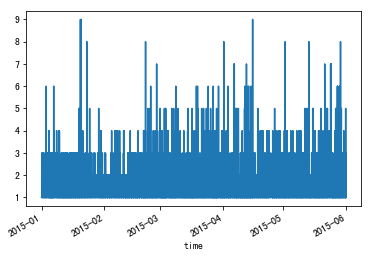

In [30]:
df_train['new_id_login_city_1D_num'].plot.line()

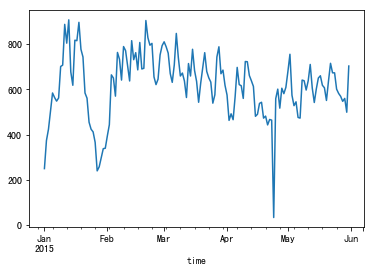

In [32]:
df_train.resample('1D')['new_id_login_city_1D_num'].count().plot.line()

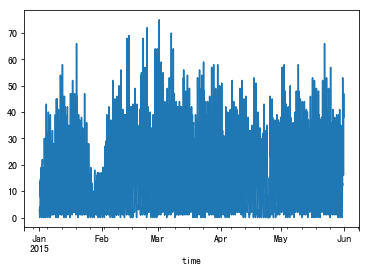

In [33]:
df_train.resample('1h')['device'].nunique().plot.line()

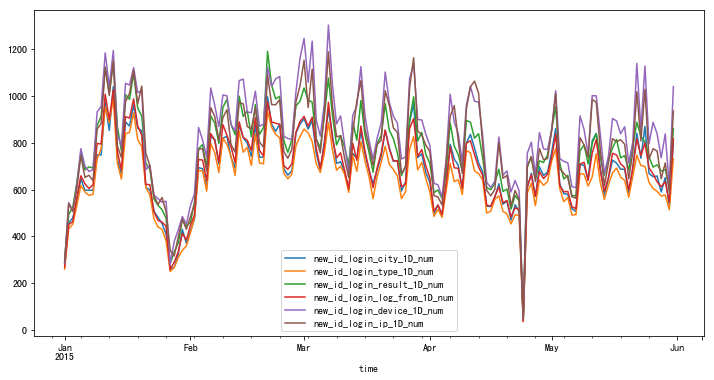

In [34]:
df_train.resample('1D')[_7d_num_cols].sum().plot.line(figsize=(12,6))

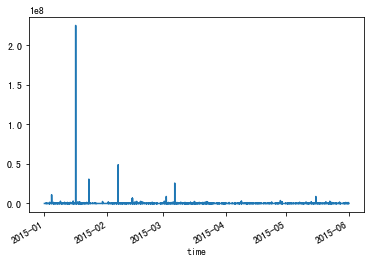

In [36]:
df_train.timelong.plot.line()

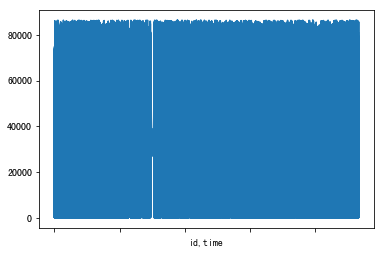

In [44]:
df_train.groupby('id').rolling('7d').new_time_delta.mean().plot.line()

In [46]:
df_train.id.value_counts().shape

(21548,)

In [ ]:
df_train.resample('1D')[_7d_cols].nunique().plot.line(figsize=(12,6))

In [ ]:
df_train.groupby('id')['device'].rolling('7D').apply(lambda x: np.unique(x).shape[0]).plot.line()

In [ ]:
df_train.groupby('id')['device'].rolling('1D').apply(lambda x: np.unique(x).shape[0]).plot.line()

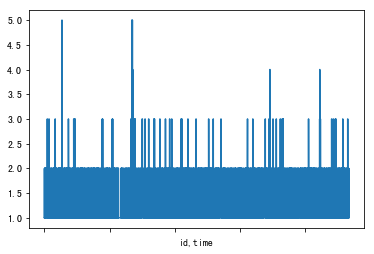

In [71]:
df_train.groupby('id')['ip'].rolling('1D').apply(lambda x: np.unique(x).shape[0]).plot.line()

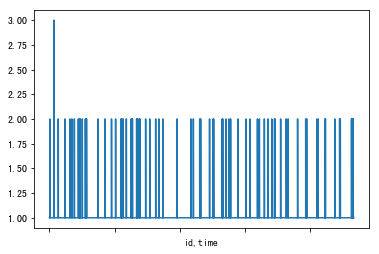

In [52]:
df_train.groupby('id')['city'].rolling('30Min').apply(lambda x: np.unique(x).shape[0]).plot.line()

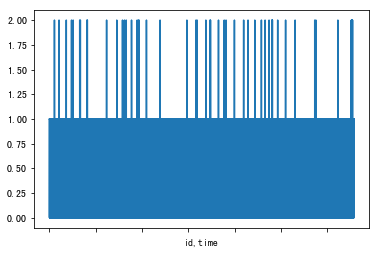

In [53]:
df_train.groupby('id')['city'].resample('30Min').nunique().plot.line()

In [35]:
df_train.new_id_login_device_7D_num.describe()

count    93489.000000
mean         1.942282
std          2.249300
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         65.000000
Name: new_id_login_device_7D_num, dtype: float64

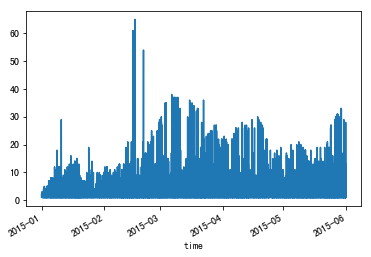

In [36]:
df_train.new_id_login_device_7D_num.plot.line()